In [1]:
import numpy as np
from pathlib import Path
from typing import List, Dict
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch
from transformers import AutoModelForSequenceClassification
import accelerate
import transformers
from transformers import DistilBertConfig, DistilBertModel, DistilBertTokenizerFast
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer


/home/ubuntu/MiniCLIP/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metadata_path = Path("../data/augmented/metadata.csv")
df = pd.read_csv(metadata_path)
print(df.columns)
print(df.iloc[1])

Index(['image_path', 'label', 'caption'], dtype='object')
image_path                                water_070_spatial.jpg
label                                               Label.WATER
caption       A kayaker wearing a blue wetsuit and black hel...
Name: 1, dtype: object


In [3]:
from enum import Enum
class Label(Enum):
    DOG = "dog"
    BIKE = "bike"
    BALL = "ball"
    WATER = "water"    


In [4]:
def get_label(filename: str):
    return filename.split("_")[0]


def get_uuid(filename: str):
    name = Path(filename).stem          
    parts = name.split("_")
    return "_".join(parts[:2])          


def build_augmented_path(img_path: Path, base_dir: Path):
    img_path = Path(img_path)
    filename = img_path.name
    label = get_label(filename)
    uuid = get_uuid(filename)
    print(uuid)

    return base_dir / label / uuid / filename

get_label(df["image_path"].iloc[1])
get_uuid(df["image_path"].iloc[1])


'water_070'

In [5]:
class PositionalEmbedding(nn.Module):
    def __init__(self, sequence_length: int, vocab_size:int, embed_dim:int):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_embeddings = nn.Embedding(sequence_length, embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        return self.token_embeddings(x) + self.position_embeddings(positions)


In [6]:
class SmallBERT(nn.Module):
    def __init__(self, sequence_length: int, vocab_size: int, embed_dim: int,
                 num_heads: int, ff_dim: int, num_layers: int) -> None:
        super().__init__()
        self.pos_embedding = PositionalEmbedding(sequence_length, vocab_size, embed_dim)
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim)
            for _ in range(num_layers)
        ])
        self.layernorm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, seq_len) token ids
        """
        padding_mask = (x == 0)  # 0 = PAD  -> True masked in attn
        x = self.pos_embedding(x)

        for block in self.blocks:
            x = block(x, padding_mask=padding_mask)

        x = self.layernorm(x)
        return self.dropout(x)


In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout_rate: float = 0.1) -> None:
        super().__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor, padding_mask: torch.Tensor = None) -> torch.Tensor:
        attn_output, _ = self.att(
            x, x, x,
            key_padding_mask=padding_mask  # <-- correct masking
        )

        x = self.layernorm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(x)
        out = self.layernorm2(x + self.dropout2(ffn_output))
        return out


In [8]:
class SmallBERTPourClassification(nn.Module):
    def __init__(self, sequence_length: int, vocab_size: int, embed_dim: int,
                 num_heads: int, ff_dim: int, num_layers: int,
                 num_classes: int = 4) -> None:
        super().__init__()

        self.encoder = SmallBERT(sequence_length, vocab_size, embed_dim, num_heads, ff_dim, num_layers)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        enc = self.encoder(x)             # (batch, seq_len, embed_dim)
        pooled = enc.mean(dim=1)          # mean pooling
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return logits  # logits only, pas softmax


In [9]:
df_clean = df.drop_duplicates(subset="caption").reset_index(drop=True)

df_train, df_temp = train_test_split(df_clean, test_size=0.3, random_state=11)
df_test, df_val = train_test_split(df_temp, test_size=0.5, random_state=11)

print(df_train["label"].value_counts(normalize=True) * 100)
print(df_val["label"].value_counts(normalize=True) * 100)
print(df_test["label"].value_counts(normalize=True) * 100)

X_train, y_train, caption_train = df_train["image_path"], df_train["label"], df_train["caption"]
X_val, y_val, caption_val  = df_val["image_path"], df_val["label"], df_val["caption"]
X_test, y_test, caption_test   = df_test["image_path"], df_test["label"], df_test["caption"]

X_train = caption_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = caption_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = caption_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("Avant :", len(df))
print("Après  :", len(df_clean))
print("Doublons supprimés :", len(df) - len(df_clean))



label
Label.WATER    25.952381
Label.BALL     25.714286
Label.DOG      24.523810
Label.BIKE     23.809524
Name: proportion, dtype: float64
label
Label.BIKE     30.000000
Label.DOG      26.666667
Label.WATER    24.444444
Label.BALL     18.888889
Name: proportion, dtype: float64
label
Label.BALL     27.777778
Label.BIKE     25.555556
Label.DOG      25.555556
Label.WATER    21.111111
Name: proportion, dtype: float64
Avant : 1800
Après  : 600
Doublons supprimés : 1200


In [10]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

420
90
90


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["caption"])
actual_vocab_size = len(tokenizer.word_index) + 1
print(f"   taille de vocabulaire: {len(tokenizer.word_index)}")
print(f"   vocab_size: {actual_vocab_size}")

2025-12-10 17:58:29.580554: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 17:58:29.607624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765389509.644073   14346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765389509.655242   14346 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-10 17:58:29.688249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

   taille de vocabulaire: 973
   vocab_size: 974


In [12]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [13]:
print(X_train[0])
print(X_train_seq[0])
print(X_test[0])
print(X_test_seq[0])

A brown dog is running through neck-deep water carrying a tennis ball .
[2, 15, 5, 8, 27, 34, 641, 390, 14, 93, 2, 74, 17]
a dirt biker turns across the dirt .
[2, 53, 47, 810, 276, 4, 53]


In [14]:
oov_id = tokenizer.word_index["<OOV>"]

count = 0
for i in range(len(X_val_seq)):
    count += X_val_seq[i].count(oov_id)

print(count)

0


In [15]:
max_seq_len = max(len(seq) for seq in X_train_seq)


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_seq_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_len, padding='post', truncating='post')


In [17]:
def normalize_label(lbl):
    if isinstance(lbl, Label):
        return lbl.value 
    if isinstance(lbl, str) and lbl.startswith("Label."):
        return lbl.split(".")[1].lower()  
    return lbl.lower()  

def encode_labels(labels, class_to_idx):
    cleaned = [normalize_label(lbl) for lbl in labels]
    return np.array([class_to_idx[lbl] for lbl in cleaned], dtype=np.int64)

classes = [lbl.value for lbl in Label]  
class_to_idx = {c: i for i, c in enumerate(classes)}
print(class_to_idx) #{'dog': 0, 'bike': 1, 'ball': 2, 'water': 3}


y_train_np = encode_labels(y_train, class_to_idx)
y_val_np   = encode_labels(y_val, class_to_idx)
y_test_np  = encode_labels(y_test, class_to_idx)



print(X_train[0])
print(X_train_seq[0])
print(X_train_padded[0])
print(y_train[0])
print(y_train_np[0])




{'dog': 0, 'bike': 1, 'ball': 2, 'water': 3}
A brown dog is running through neck-deep water carrying a tennis ball .
[2, 15, 5, 8, 27, 34, 641, 390, 14, 93, 2, 74, 17]
[  2  15   5   8  27  34 641 390  14  93   2  74  17   0   0   0   0   0
   0   0   0   0   0   0   0]
Label.DOG
0


In [18]:
oov_id = tokenizer.word_index.get("<OOV>", 1)
def count_oov_pct(sequences, oov_id):
    total = sum(1 for seq in sequences for tid in seq if tid != 0)
    oov = sum(1 for seq in sequences for tid in seq if tid == oov_id)
    return oov/total*100 if total > 0 else 0

print(f"\n<OOV>pourcentage:")
print(f"  Train: {count_oov_pct(X_train_seq, oov_id):.1f}%")
print(f"  Val:   {count_oov_pct(X_val_seq, oov_id):.1f}%")
print(f"  Test:  {count_oov_pct(X_test_seq, oov_id):.1f}%")


<OOV>pourcentage:
  Train: 0.0%
  Val:   0.0%
  Test:  0.0%


In [19]:
print(f"  \nTrain: X={X_train_padded.shape}, y={y_train_np.shape}")
print(f"  Val:   X={X_val_padded.shape}, y={y_val_np.shape}")
print(f"  Test:  X={X_test_padded.shape}, y={y_test_np.shape}")

  
Train: X=(420, 25), y=(420,)
  Val:   X=(90, 25), y=(90,)
  Test:  X=(90, 25), y=(90,)


In [20]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(torch.tensor(X_train_padded), torch.tensor(y_train_np))
val_ds   = TensorDataset(torch.tensor(X_val_padded), torch.tensor(y_val_np))
test_ds  = TensorDataset(torch.tensor(X_test_padded), torch.tensor(y_test_np))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)


In [34]:
vocab_size = actual_vocab_size  # si tu as +1 pour PAD
model = SmallBERTPourClassification(
    vocab_size=vocab_size,
    sequence_length=25,
    embed_dim=128,
    num_heads=4,
    ff_dim=256,
    num_layers=2,
    num_classes=4
).to("cuda")




In [35]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.should_stop = False

    def step(self, metric):
        if self.best_score is None:
            self.best_score = metric
        elif metric < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_score = metric
            self.counter = 0


In [36]:
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            preds.extend(pred.cpu().numpy())
            labels.extend(y.cpu().numpy())
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return acc, f1


In [40]:
from sklearn.metrics import accuracy_score, f1_score

early = EarlyStopping(patience=10)

for epoch in range(100):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # validation
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_true.extend(y.cpu().numpy())

    val_acc = accuracy_score(all_true, all_preds)
    val_f1 = f1_score(all_true, all_preds, average="macro")

    print(f"Epoch {epoch+1} | loss={total_loss/len(train_loader):.4f} | acc={val_acc:.4f} | f1={val_f1:.4f}")

    early.step(val_f1)
    if early.should_stop:
        print("Early stopping triggered.")
        break


Epoch 1 | loss=0.0160 | acc=0.7111 | f1=0.6954
Epoch 2 | loss=0.0235 | acc=0.6889 | f1=0.6654
Epoch 3 | loss=0.0176 | acc=0.7333 | f1=0.7184
Epoch 4 | loss=0.0157 | acc=0.7333 | f1=0.7120
Epoch 5 | loss=0.0386 | acc=0.7222 | f1=0.7085
Epoch 6 | loss=0.0731 | acc=0.7444 | f1=0.7275
Epoch 7 | loss=0.0739 | acc=0.6889 | f1=0.6684
Epoch 8 | loss=0.0407 | acc=0.6778 | f1=0.6591
Epoch 9 | loss=0.0221 | acc=0.7000 | f1=0.6814
Epoch 10 | loss=0.0278 | acc=0.7222 | f1=0.7160
Epoch 11 | loss=0.0159 | acc=0.7000 | f1=0.6842
Epoch 12 | loss=0.0074 | acc=0.7222 | f1=0.7109
Epoch 13 | loss=0.0042 | acc=0.7444 | f1=0.7323
Epoch 14 | loss=0.0021 | acc=0.7444 | f1=0.7319
Epoch 15 | loss=0.0024 | acc=0.7333 | f1=0.7210
Epoch 16 | loss=0.0016 | acc=0.7111 | f1=0.6973
Epoch 17 | loss=0.0014 | acc=0.7333 | f1=0.7200
Epoch 18 | loss=0.0013 | acc=0.7333 | f1=0.7199
Epoch 19 | loss=0.0010 | acc=0.7333 | f1=0.7199
Epoch 20 | loss=0.0011 | acc=0.7333 | f1=0.7199
Epoch 21 | loss=0.0009 | acc=0.7444 | f1=0.7316
E

In [41]:
from sklearn.metrics import confusion_matrix

model.eval()

all_preds, all_labels = [], []
all_probs = []
embeddings = []
labels = []


with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        enc = model.encoder(x)  # (batch, seq_len, embed_dim)
        emb = enc.mean(dim=1).cpu().numpy()  # (batch, embed_dim)

        embeddings.append(emb)
        labels.extend(y.numpy())

        logits = model(x)
        probs = F.softmax(logits, dim=-1)  
        pred = probs.argmax(dim=1)
        
        all_preds.extend(pred.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y.numpy())

embeddings = np.vstack(embeddings)
labels = np.array(labels)
test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average="macro")
cm = confusion_matrix(all_labels, all_preds)
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Test accuracy:", test_acc)
print("Test F1:", test_f1)
print(cm)
print("\nMatrice de confusion :\n")
print("          Prédit")
print("           ", "   ".join([f"{idx_to_class[i]:>6}" for i in range(len(idx_to_class))]))
print("Réel")
for i in range(len(idx_to_class)):
    row = "   ".join([f"{cm[i][j]:>6}" for j in range(len(idx_to_class))])
    print(f"{idx_to_class[i]:>6}  {row}")


Test accuracy: 0.7444444444444445
Test F1: 0.7329125046244913
[[18  0  5  1]
 [ 0 23  0  4]
 [ 1  2 11  3]
 [ 5  1  1 15]]

Matrice de confusion :

          Prédit
               dog     bike     ball    water
Réel
   dog      18        0        5        1
  bike       0       23        0        4
  ball       1        2       11        3
 water       5        1        1       15


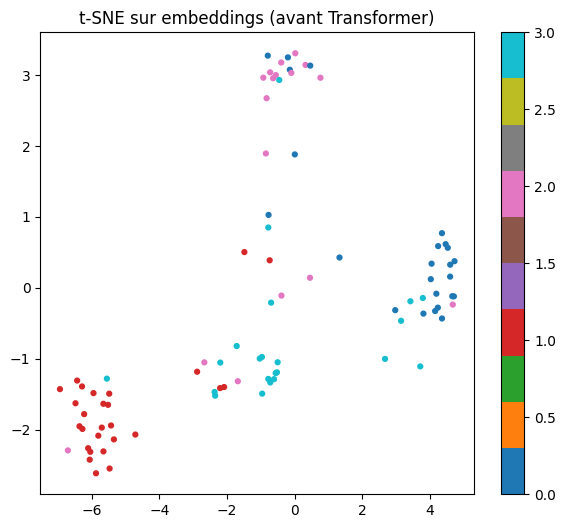

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, learning_rate="auto", init="pca")
emb2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(7,6))
plt.scatter(emb2d[:,0], emb2d[:,1], c=labels, cmap="tab10", s=12)
plt.title("t-SNE sur embeddings (avant Transformer)")
plt.colorbar()
plt.show()


In [43]:
def predict_caption(model, caption, tokenizer, max_length):
    model.eval()
    seq = tokenizer.texts_to_sequences([caption])
    seq = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
    x = torch.tensor(seq, dtype=torch.long).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=-1)
        pred = probs.argmax(dim=-1).item()

    return pred, probs.cpu().numpy()

caption = "A dog with a ball in the water"
pred, probs = predict_caption(model, caption, tokenizer, 25)

print(pred, probs)


0 [[5.7348567e-01 2.7999076e-05 4.2404473e-01 2.4415941e-03]]
